# Mental health and substance use disorders -- Modeling


### Outline:
1.   Problem Identification 

2.   Data Wrangling 
 
3.   Exploratory Data Analysis

4.   Pre-processing and Training Data Development

5.   **Modeling**
     * Fit Models with Data Set
     * Review Model Outcomes with visualization.
     * Identify the Final Model
     
6.   Documentation

## Overview
In this notebook, I will use the gender data frame to identify the country outliers using unsupervised clustering machine learning. The data is an unlabeled anomaly, so we can only model this with an unsupervised method. Here I will use a few different models and choose the best one.

The methods I will apply:
     * Isolation Forest
     * One-Class SVM
     * DBSCAN
     * Local Outlier Factor (LOF)
     * Elliptic Envelope
 
For each method, I visualized the accuracy of the model and compared normal and abnormal points identified, **One-Class SVM** model had better predict on the outliers. 

**First, let's load the data.**

In [1]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
path = os.getcwd()
print ("The current working directory is %s" % path)

The current working directory is C:\Users\yuhan\Desktop\Springboard\Capstone project-2


In [3]:
os.listdir()

['.ipynb_checkpoints',
 'Capstone Two - Project Proposal.pdf',
 'data',
 'figures',
 'Mental health and substance disorders data',
 'Mental health and substance use disorders_data wrangling.ipynb',
 'Mental health and substance use disorders_EDA.ipynb',
 'Mental health and substance use disorders_Modeling.ipynb',
 'Mental health and substance use disorders_Pre-Processing and Training Data Development.ipynb',
 'models',
 'Project final report.pdf',
 'README.md']

In [4]:
path = 'data'
os.chdir(path)

In [5]:
os.listdir()

['GDP_per_capita_output.csv',
 'mental_substance_age_output.csv',
 'mental_substance_gdp_output.csv',
 'mental_substance_gender_output.csv',
 'mental_substance_output.csv']

In [6]:
df = pd.read_csv('mental_substance_gender_output.csv', index_col=0)
df.head()

,Entity,Code,Year,Male (%),Female (%)
0,Afghanistan,AFG,1990,17.448695,17.634233
1,Afghanistan,AFG,1991,17.771263,17.873184
2,Afghanistan,AFG,1992,18.051575,18.092318
3,Afghanistan,AFG,1993,18.275848,18.265196
4,Afghanistan,AFG,1994,18.427490,18.383394


**Let's focus only focus on 2017 data first.**

### Data preparation

In [7]:
df_2017 = df[df.Year==2017]
df_2017.head()

,Entity,Code,Year,Male (%),Female (%)
27,Afghanistan,AFG,2017,16.674168,16.963023
55,Albania,ALB,2017,10.646518,11.043173
83,Algeria,DZA,2017,14.063803,15.011597
111,American Samoa,ASM,2017,10.687930,11.004269
139,Andean Latin America,NaN,2017,11.973561,12.787111


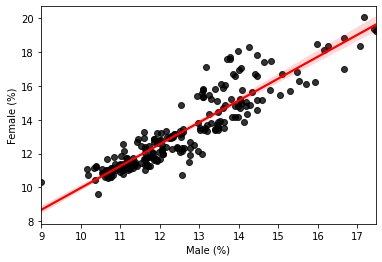

In [8]:
sns.regplot(x='Male (%)', y='Female (%)', data=df_2017, scatter_kws={"color": "black"}
           , line_kws={"color": "red"})

Mental and substance use disorders rates in males and females are positively correlated.

From the above correlation chart, we can see that some of the data points are obvious outliers such as far away from other data points. 

In [9]:
data = df_2017.drop(columns=['Code', 'Year'])
data = data.reset_index(drop=True)
data.head()

,Entity,Male (%),Female (%)
0,Afghanistan,16.674168,16.963023
1,Albania,10.646518,11.043173
2,Algeria,14.063803,15.011597
3,American Samoa,10.687930,11.004269
4,Andean Latin America,11.973561,12.787111


In [10]:
#specify the Male and Female column names to be modelled
model_data = data[['Male (%)', 'Female (%)']]
model_data.head()

,Male (%),Female (%)
0,16.674168,16.963023
1,10.646518,11.043173
2,14.063803,15.011597
3,10.687930,11.004269
4,11.973561,12.787111


# Modeling


## Isolation Forest

Isolation Forest is an unsupervised learning algorithm that identifies anomaly by isolating outliers in the data and based on the Decision Tree algorithm that also works well in higher-dimensional sets. 

I am using sklearn’s Isolation Forest here as it is a small dataset.

In [11]:
from sklearn.ensemble import IsolationForest
iforest=IsolationForest(n_estimators=100, max_samples='auto', contamination=0.05, random_state=42)
iforest.fit(model_data)
df_iforest = data.copy()

# add anomaly scores column 
df_iforest['scores'] = iforest.decision_function(model_data)


# add anomaly column
df_iforest['anomaly']=iforest.predict(model_data)

outliers_iforest = df_iforest[df_iforest['anomaly']==-1]

#Find the number of anomalies and normal points here points classified -1 are anomalous
print(df_iforest['anomaly'].value_counts())

 1    219
-1     12
Name: anomaly, dtype: int64


In [12]:
outliers_iforest

,Entity,Male (%),Female (%),scores,anomaly
0,Afghanistan,16.674168,16.963023,-0.045159,-1
10,Australasia,17.426564,19.354329,-0.096603,-1
11,Australia,17.468624,19.216194,-0.097537,-1
46,Colombia,10.433445,9.632960,-0.098532,-1
73,France,14.253098,18.315089,-0.013342,-1
80,Greenland,16.660937,18.847410,-0.063311,-1
97,Iran,17.059424,18.374773,-0.056481,-1
143,New Zealand,17.180899,20.077960,-0.151444,-1
148,North America,16.168288,18.085483,-0.014763,-1
150,Northern Ireland,15.978954,18.454494,-0.028465,-1


### Evaluating the model with Visualization

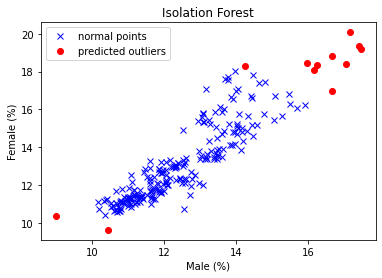

In [13]:
normal_iforest =df_iforest[df_iforest['anomaly']==1]

plt.figure()
plt.title("Isolation Forest")
plt.plot(normal_iforest['Male (%)'],normal_iforest['Female (%)'],'bx',label="normal points")
plt.plot(outliers_iforest['Male (%)'],outliers_iforest['Female (%)'],'ro',label="predicted outliers")
plt.xlabel('Male (%)')
plt.ylabel('Female (%)')
plt.legend(loc="upper left")
plt.show()

## One-Class SVM 

One-Clase SVM can fit a tight decision boundary around a set of normal points.

The nu parameter should be the proportion of outliers you expect to observe. 

The gamma parameter determines the smoothing of the contour lines.

In [14]:
from sklearn.svm import OneClassSVM

In [15]:
ocsvm = OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
ocsvm.fit(model_data)

df_svm = data.copy()

# add anomaly scores column 
df_svm['scores'] = ocsvm.decision_function(model_data)

# add anomaly column
df_svm['anomaly'] = ocsvm.predict(model_data)

outliers_svm = df_svm[df_svm['anomaly']==-1]

#Find the number of anomalies and normal points here points classified -1 are anomalous
print(df_svm['anomaly'].value_counts())

 1    220
-1     11
Name: anomaly, dtype: int64


In [16]:
outliers_svm

,Entity,Male (%),Female (%),scores,anomaly
0,Afghanistan,16.674168,16.963023,-0.000394,-1
10,Australasia,17.426564,19.354329,-0.018118,-1
11,Australia,17.468624,19.216194,-0.000024,-1
44,Chile,13.967695,18.032065,-0.000024,-1
46,Colombia,10.433445,9.632960,-0.293489,-1
77,Germany,13.177177,17.103987,-0.081881,-1
95,India,14.458852,14.574554,-0.000439,-1
114,Lesotho,14.141597,13.881278,-0.051432,-1
143,New Zealand,17.180899,20.077960,-0.273713,-1
223,Vietnam,8.988939,10.346828,-0.650662,-1


### Evaluating the model with Visualization

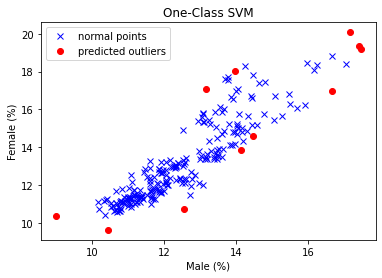

In [17]:
normal_svm =df_svm[df_svm['anomaly']==1]

plt.figure()
plt.title("One-Class SVM")
plt.plot(normal_svm['Male (%)'],normal_svm['Female (%)'],'bx',label="normal points")
plt.plot(outliers_svm['Male (%)'],outliers_svm['Female (%)'],'ro',label="predicted outliers")
plt.xlabel('Male (%)')
plt.ylabel('Female (%)')
plt.legend(loc="upper left")

plt.savefig(r'C:\Users\yuhan\Desktop\Springboard\Capstone project-2\figures\One_class_SVM.png', bbox_inches = 'tight')

## Density-based Spatial Clustering of Applications with Noise (DBSCAN)

DBSCAN is a clustering algorithm that’s used cluster data into groups. It is also used as a density-based anomaly detection method with either single or multi-dimensional data. 

DBSCAN works by running a connected components algorithm across the different core points. If two core points share border points, or a core point is a border point in another core point’s neighborhood, then they’re part of the same connected component, which forms a cluster.

min_samples is the minimum number of points needed to constitute a cluster.

eps is the maximum distance between two samples for them to be considered as in the same cluster.

In [18]:
from sklearn.cluster import DBSCAN

In [19]:
dbscan = DBSCAN(min_samples = 6, eps = 1)

dbscan.fit(model_data)

df_dbscan = data.copy()


# add anomaly column
df_dbscan['anomaly']=dbscan.fit_predict(model_data)

outliers_dbscan = df_dbscan[df_dbscan['anomaly']==-1]

#Find the number of anomalies and normal points here points classified -1 are anomalous
print(df_dbscan['anomaly'].value_counts())

 0    221
 1      7
-1      3
Name: anomaly, dtype: int64


In [20]:
outliers_dbscan

,Entity,Male (%),Female (%),anomaly
0,Afghanistan,16.674168,16.963023,-1
143,New Zealand,17.180899,20.077960,-1
223,Vietnam,8.988939,10.346828,-1


### Evaluating the model with silhouette score

In [21]:
labels = dbscan.labels_

In [22]:
from sklearn import metrics
print(metrics.silhouette_score(model_data, labels))

0.48419575381395497


A silhouette score ranges from -1 to 1, with -1 being the worst score possible and 1 being the best score. Silhouette scores of 0 suggest overlapping clusters.

### Evaluating the model with Visualization

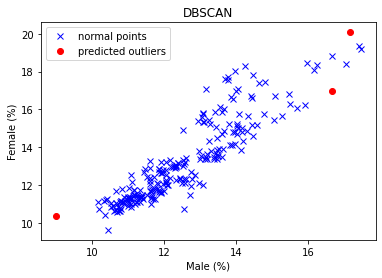

In [23]:
normal_dbscan =df_dbscan[(df_dbscan['anomaly']==1) | (df_dbscan['anomaly']==0)]

plt.figure()
plt.title("DBSCAN")
plt.plot(normal_dbscan['Male (%)'],normal_dbscan['Female (%)'],'bx',label="normal points")
plt.plot(outliers_dbscan['Male (%)'],outliers_dbscan['Female (%)'],'ro',label="predicted outliers")
plt.xlabel('Male (%)')
plt.ylabel('Female (%)')
plt.legend(loc="upper left")
plt.show()

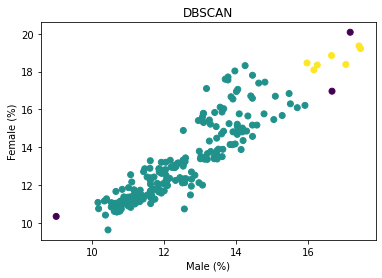

In [24]:
plt.figure()
plt.title("DBSCAN")
plt.scatter(model_data['Male (%)'], model_data['Female (%)'], c = labels)
plt.xlabel('Male (%)')
plt.ylabel('Female (%)')
plt.show()

## Local Outlier Factor (LOF)


  LOF uses density-based outlier detection to identify local outliers, points that are outliers with respect to their local neighborhood, rather than with respect to the global data distribution. 
  

In [25]:
from sklearn.neighbors import LocalOutlierFactor 

# K is set by passing the n_neighbors parameter with integer. 
# 20 is often considered good already to detect an outlier. By default the distance metric is Euclidean distance.

lof = LocalOutlierFactor(n_neighbors = 20)

lof.fit(model_data)

df_lof = data.copy()

# add anomaly column
df_lof['anomaly'] = lof.fit_predict(model_data)

#Getting the negative LOF score
df_lof['negative_outlier_factor'] = lof.negative_outlier_factor_

outliers_lof = df_lof[df_lof['anomaly']==-1]

#Find the number of anomalies and normal points here points classified -1 are anomalous
print(df_lof['anomaly'].value_counts())

 1    221
-1     10
Name: anomaly, dtype: int64


In [26]:
outliers_lof

,Entity,Male (%),Female (%),anomaly,negative_outlier_factor
10,Australasia,17.426564,19.354329,-1,-1.683786
11,Australia,17.468624,19.216194,-1,-1.667650
32,Cambodia,11.005699,11.864834,-1,-1.524956
46,Colombia,10.433445,9.632960,-1,-2.855041
125,Maldives,10.653009,11.666074,-1,-1.542887
130,Mauritius,10.828345,11.775893,-1,-1.510253
140,Namibia,12.730088,11.479818,-1,-1.570546
143,New Zealand,17.180899,20.077960,-1,-1.781622
223,Vietnam,8.988939,10.346828,-1,-3.452915
230,Zimbabwe,12.561063,10.740696,-1,-2.700718


Outlier depends on the LOF score. By default, if the score of the negative_outlier_score is less than -1.5, it would be considered as the outlier.

### Evaluating the model with Visualization

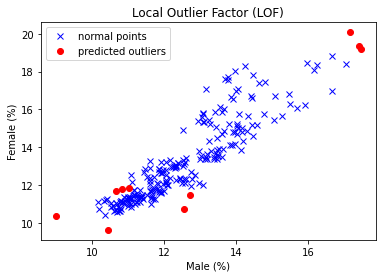

In [27]:
normal_lof =df_lof[df_lof['anomaly']==1]

plt.figure()
plt.title("Local Outlier Factor (LOF)")
plt.plot(normal_lof['Male (%)'],normal_lof['Female (%)'],'bx',label="normal points")
plt.plot(outliers_lof['Male (%)'],outliers_lof['Female (%)'],'ro',label="predicted outliers")
plt.xlabel('Male (%)')
plt.ylabel('Female (%)')
plt.legend(loc="upper left")
plt.show()

## Elliptic Envelope

Elliptic Envelope fits the tightest Gaussian (smallest volume ellipsoid) that it can while discarding some fixed fraction of contamination points set by the user.

The algorithm — Elliptical Envelope— creates an imaginary elliptical area around a given dataset. Values that fall inside the envelope are considered normal data and anything outside the envelope is returned as outliers. The algorithm works best if data has a Gaussian distribution.

In [28]:
from sklearn.covariance import EllipticEnvelope

df_ee = data.copy()

ee = EllipticEnvelope(contamination=.05)
ee.fit(model_data)

# add scores column
df_ee['scores'] = ee.decision_function(model_data)

# add anomaly column
df_ee['anomaly'] = ee.predict(model_data)

outliers_ee = df_ee[df_ee['anomaly']==-1]

#Find the number of anomalies and normal points here points classified -1 are anomalous
print(df_ee['anomaly'].value_counts())

 1    219
-1     12
Name: anomaly, dtype: int64


In [29]:
outliers_ee

,Entity,Male (%),Female (%),scores,anomaly
8,Argentina,13.698439,17.598748,-19.662857,-1
10,Australasia,17.426564,19.354329,-3.024002,-1
11,Australia,17.468624,19.216194,-2.009647,-1
44,Chile,13.967695,18.032065,-23.929459,-1
73,France,14.253098,18.315089,-24.185380,-1
77,Germany,13.177177,17.103987,-20.256060,-1
80,Greenland,16.660937,18.847410,-0.052283,-1
143,New Zealand,17.180899,20.077960,-12.519582,-1
190,Southern Latin America,13.776901,17.715801,-20.652909,-1
192,Spain,14.458826,17.804548,-8.383332,-1


### Evaluating the model with Visualization

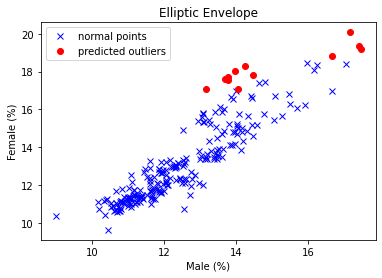

In [30]:
normal_ee =df_ee[df_ee['anomaly']==1]

plt.figure()
plt.title("Elliptic Envelope")
plt.plot(normal_ee['Male (%)'],normal_ee['Female (%)'],'bx',label="normal points")
plt.plot(outliers_ee['Male (%)'],outliers_ee['Female (%)'],'ro',label="predicted outliers")
plt.xlabel('Male (%)')
plt.ylabel('Female (%)')
plt.legend(loc="upper left")
plt.show()

# Identify the Final Model

From the figures for normal and outlier points, it looks like **One-Class** SVM better predict the outliers. 